## 作业2：ADAMS和RK4数值积分的实现
仿照run_euler函数的实现，在modsim中实现Adams和四阶Runge-Kutta法，并使用炮弹发射仿真比较Euler、Adams和RK4三种数值积分的精度。实现run_adams和run_rk4函数。

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

import numpy as np

In [2]:
t = 0.0
t_1 = 0.03 #为adams提供初值进行euler法时间
t_end = 6.0
g = 9.8   #重力加速度
v0 =500.0
x0 = 0.0
y0 = 100.0
dt = 0.01

init_z = State(y=100.0, v=0.0)
init_x = State(y=0.0, v=500.0)

,values
y,0.0
v,500.0


In [3]:
# 欧拉法

In [4]:
def slope_func_z(state, t, system):
    y, v = state
    
    dydt = -system.g*t
    dvdt = -system.g
    
    return dydt, dvdt

def slope_func_x(state, t, system):
    y, v = state
    
    dydt = v
    dvdt = 0.0 
    
    return dydt, dvdt

In [5]:
system_z = System(init=init_z, g=g, t_end=t_end, dt=dt)
system_x = System(init=init_x, t_end=t_end, dt=dt)

,values
init,y 0.0 v 500.0 dtype: float64
t_end,6
dt,0.01


In [6]:
def modified_run_euler(system, slope_func,**options):
    '''从modsim.py中找到run_euler的源代码，然后进行了修改'''

    # the default message if nothing changes
    msg = "The solver successfully reached the end of the integration interval."

    # get parameters from system
    init, t_0, t_end, dt = check_system(system, slope_func)

    # make the TimeFrame
    tss=[]
    tss.append(t_0)
    frame = TimeFrame(columns=init.index)
    frame.row[t_0] = init
    ts = linrange(t_0, t_end, dt) * get_units(t_end)
    # run the solver
    for t1 in ts: 
        y1 = frame.row[t1]
        if y1.y>=0:   #判断是否到达地面
            slopes = slope_func(y1, t1, system)
            y2 = [y + slope * dt for y, slope in zip(y1, slopes)]
            t2 = t1 + dt
            tss.append(t2)
            frame.row[t2] = y2    
        else:
            break
    
    details = ModSimSeries(dict(message="Success"))
    return frame, details,tss

ts_x, ts_z = [], []
    
results_z, details_z, ts_z = modified_run_euler(system_z, slope_func_z)
results_x, details_x, ts_x = modified_run_euler(system_x, slope_func_x)

In [7]:
zs, xs = [], []
for y in results_z.y:
    zs.append(y)

for y in results_x.y:
    xs.append(y)

max error_x : 0.00000


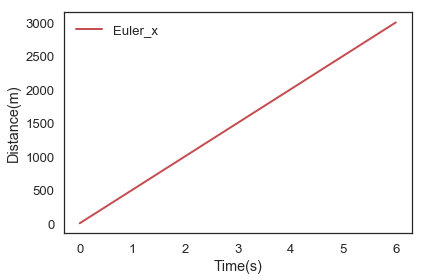

In [8]:
exact_x = [v0*t for t in ts_x]
error_x = abs(np.array(exact_x) - np.array(xs))

print("max error_x : {:.5f}".format(max(error_x)))
plot(ts_x, xs,'r', label='Euler_x')
decorate(xlabel='Time(s)',
         ylabel='Distance(m)')

max Euler_error_y : 0.22197


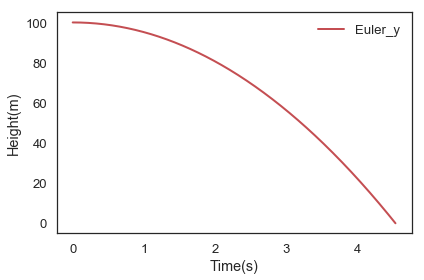

In [9]:
exact_y = [y0-0.5*g*t*t for t in ts_z]
Euler_error_y = abs(np.array(exact_y) - np.array(zs))

print("max Euler_error_y : {:.5f}".format(max(Euler_error_y)))
plot(ts_z, zs,'r', label='Euler_y')
decorate(xlabel='Time(s)',
         ylabel='Height(m)')

In [10]:
# 四阶Adams法

In [11]:
system_z = System(init=init_z, t_0=0, g=g, t_end=t_1, dt=dt)
system_x = System(init=init_x, t_0=0, t_end=t_1, dt=dt)

,values
init,y 0.0 v 500.0 dtype: float64
t_0,0
t_end,0.03
dt,0.01


In [12]:
# 使用欧拉法为adams法提供4个初值
results_z, details_z = run_euler(system_z, slope_func_z)
results_x, details_x = run_euler(system_x, slope_func_x)

In [13]:
ys, xs, ts_x, ts_y=[], [], [], []
for y in results_z.y:
    ys.append(y)

for y in results_x.y:
    xs.append(y)

i = 1
t_ = t
while i<= 4:
    ts_x.append(t_)
    ts_y.append(t_)
    t_ += dt
    i += 1

In [14]:
def f_x(x, t):
    return v0

def f_y(y, t):
    return -g*t

def result(y_0, x_0, y_1, x_1, y_2, x_2, y_3, x_3, h, f):
    y_4 = y_3 + (-9.*f(y_0, x_0)+ 37.*f(y_1, x_1)- 59.*f(y_2, x_2) + 55.*f(y_3, x_3))* h / 24.
    return y_4

def run_adams(y_s, x_s, x_end,h,f):
    i = 0
    y = y_s[-1]
    x = x_s[-1]
    while x_s[-1] <= x_end:  
        if y >= 0:               
            y = result(y_s[i],x_s[i], y_s[i+1],x_s[i+1], y_s[i+2],x_s[i+2], y_s[i+3],x_s[i+3],h,f)
            y_s.append(y)
            i += 1  
            x += h
            x_s.append(x)
        else:
            break
    return y_s,x_s

In [15]:
ys_final, xs_final, ts_final=[], [], []

max error_x : 0.00000


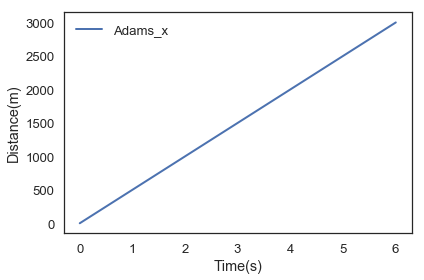

In [16]:
xs_final, ts_final= run_adams(xs,ts_x,t_end,dt,f_x)
exact_x = [v0*t for t in ts_final]
error_x = abs(np.array(exact_x) - np.array(xs_final))

print("max error_x : {:.5f}".format(max(error_x)))
plot(ts_final, xs_final, label='Adams_x')
decorate(xlabel='Time(s)',
         ylabel='Distance(m)')

max Adams_error_y : 0.00147


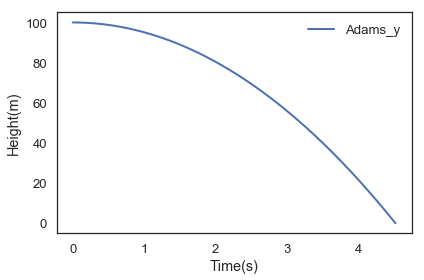

In [17]:
ys_final, ts_final= run_adams(ys,ts_y,t_end,dt,f_y)
exact_y = [y0-0.5*g*t*t for t in ts_final]
Adams_error_y = abs(np.array(exact_y) - np.array(ys_final))

print("max Adams_error_y : {:.5f}".format(max(Adams_error_y)))
plot(ts_final, ys_final, label='Adams_y')
decorate(xlabel='Time(s)',
         ylabel='Height(m)')

In [18]:
# 四阶Runge-Kutta法

In [19]:
xs, ys, ts_x, ts_y = [], [], [], []

In [20]:
def f_x(t, x):
    return v0

def f_y(t, y):
    return -g*t

def run_rk4(y, x, x_end, h, f):
    """ y is the initial value for y
        x is the initial value for x
        h is the time step in x
        f is derivative of function y(t)
    """
    y_s, x_s = [], []
    while x <= x_end:  
        if y >= 0:               
            k1 = f(x, y)
            k2 = f(x+0.5 * h, y+0.5* h * k1)
            k3 = f(x+0.5 * h, y+0.5* h * k2)
            k4 = f(x+h, y+h * k3)
            y = y + (k1+ 2.*k2+ 2.*k3+ k4)* h / 6.
            x += h
            y_s.append(y)
            x_s.append(x)  
           
        else:
            break
    return y_s,x_s

max error_x : 0.00000


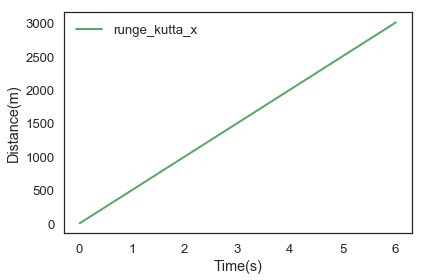

In [21]:
xs,ts_x = run_rk4(x0, t, t_end, dt, f_x)
exact_x = [v0*t for t in ts_x]
error_x = abs(np.array(exact_x) - np.array(xs))

print("max error_x : {:.5f}".format(max(error_x)))
plot(ts_x, xs,'g',label='runge_kutta_x')
decorate(xlabel='Time(s)',
         ylabel='Distance(m)')

max RK4_error_y : 0.00000


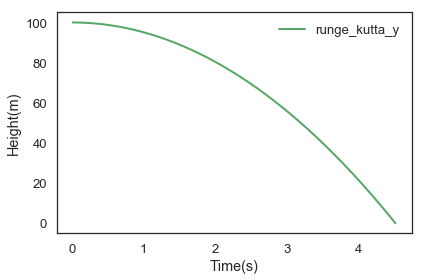

In [22]:
ys,ts_y = run_rk4(y0, t, t_end, dt, f_y)
exact_y = [y0-0.5*g*t*t for t in ts_y]
RK4_error_y = abs(np.array(exact_y) - np.array(ys))

print("max RK4_error_y : {:.5f}".format(max(RK4_error_y)))
plot(ts_y, ys,'g',label='runge_kutta_y')
decorate(xlabel='Time(s)',
         ylabel='Height(m)')

In [23]:
print("由上述过程可知 max RK4_error_y = 0.00000 < max Adams_error_y = 0.00147 < max Euler_error_y = 0.22197 ")

由上述过程可知 max RK4_error_y = 0.00000 < max Adams_error_y = 0.00147 < max Euler_error_y = 0.22197 


In [24]:
print("所以 四阶Runge Kutta法精度 > 四阶Adams算法精度 > Euler法精度 ")

所以 四阶Runge Kutta法精度 > 四阶Adams算法精度 > Euler法精度 
